# COVID-19 CT Infection Segmentation

In [13]:
import os
import cv2
from PIL import Image
import numpy as np
from glob import glob
import random
import matplotlib.pyplot as plt
from keras.utils import normalize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import keras
from keras.layers import *
from tensorflow.keras import layers as L
import tensorflow.keras.backend as K
from keras.callbacks import ModelCheckpoint

# Data Preprocessing

In [14]:
SIZE = 224

## Training Data

In [19]:
train_image_directory = glob("/kaggle/input/mymosmed-clahe-refined-slices-train-test/train/ct_scans/*.png")
train_image_directory.sort()
train_mask_directory = glob("/kaggle/input/mymosmed-clahe-refined-slices-train-test/train/masks/*.png")
train_mask_directory.sort()

In [20]:
train_images = []
train_masks = []

In [21]:
len(train_image_directory), len(train_mask_directory)

(509, 509)

In [23]:
train_image_directory[80], train_mask_directory[80]

('/kaggle/input/mymosmed-clahe-refined-slices-train-test/train/ct_scans/study_0263_Slice_19.png',
 '/kaggle/input/mymosmed-clahe-refined-slices-train-test/train/masks/study_0263_Slice_19.png')

In [24]:
for image_name in train_image_directory:
    if (image_name.split('.')[1]=='png'):
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (SIZE,SIZE))
        #image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        train_images.append(np.array(image))

In [25]:
for mask_name in train_mask_directory:
    if (mask_name.split('.')[1]=='png'):
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE, SIZE))
        #mask = Image.fromarray(mask)
        #mask = mask.resize((SIZE, SIZE))
        train_masks.append(np.array(mask))

In [26]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)

In [27]:
train_images.shape, train_masks.shape

((509, 224, 224, 3), (509, 224, 224))

# Testing Data

In [28]:
test_image_directory = glob("/kaggle/input/mymosmed-clahe-refined-slices-train-test/test/ct_scans/*.png")
test_image_directory.sort()
test_mask_directory = glob("/kaggle/input/mymosmed-clahe-refined-slices-train-test/test/masks/*.png")
test_mask_directory.sort()

In [29]:
test_images = []
test_masks = []

In [30]:
len(test_image_directory), len(test_image_directory)

(128, 128)

In [32]:
test_image_directory[20], test_mask_directory[20]

('/kaggle/input/mymosmed-clahe-refined-slices-train-test/test/ct_scans/study_0263_Slice_11.png',
 '/kaggle/input/mymosmed-clahe-refined-slices-train-test/test/masks/study_0263_Slice_11.png')

In [33]:
for image_name in test_image_directory:
    if (image_name.split('.')[1]=='png'):
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (SIZE,SIZE))
        #image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        test_images.append(np.array(image))

In [34]:
for mask_name in test_mask_directory:
    if (mask_name.split('.')[1]=='png'):
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE, SIZE))
        #mask = Image.fromarray(mask)
        #mask = mask.resize((SIZE, SIZE))
        test_masks.append(np.array(mask))

In [35]:
test_images = np.array(test_images)
test_masks = np.array(test_masks)

In [36]:
test_images.shape, test_masks.shape

((128, 224, 224, 3), (128, 224, 224))

## Rescaling Images

In [37]:
train_images = train_images/255.
test_images = test_images/255.

## Expand Dimensions and Rescaling Masks

In [38]:
train_masks = np.expand_dims((train_masks),3) /255.

In [39]:
train_masks.shape

(509, 224, 224, 1)

In [40]:
test_masks = np.expand_dims((test_masks),3) /255.

In [41]:
test_masks.shape

(128, 224, 224, 1)

## Defining X_train, X_test, y_train and y_test

In [42]:
X_train = train_images
y_train = train_masks
X_test = test_images
y_test = test_masks

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((509, 224, 224, 3),
 (128, 224, 224, 3),
 (509, 224, 224, 1),
 (128, 224, 224, 1))

# Visualize Images and Corresponding Masks

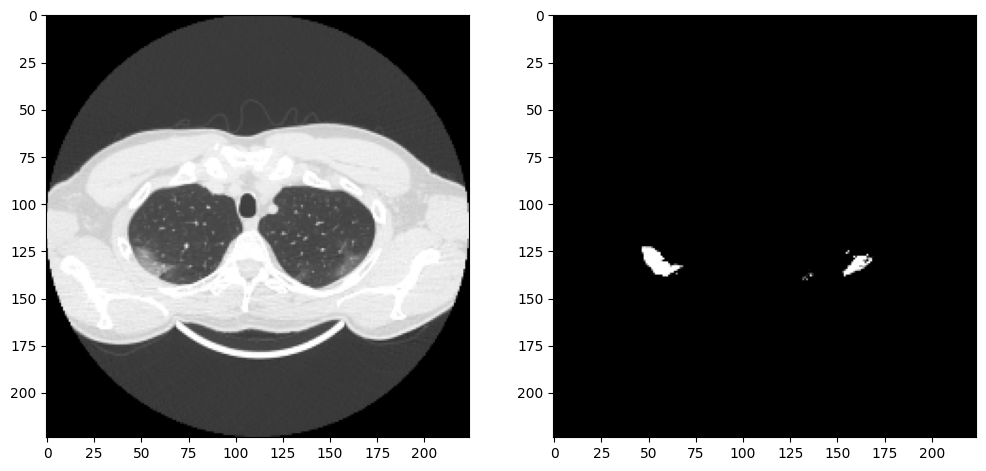

In [44]:
image_number = random.randint(0, len(train_images))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(train_images[image_number])
plt.subplot(122)
plt.imshow(train_masks[image_number], cmap='gray')
plt.show()

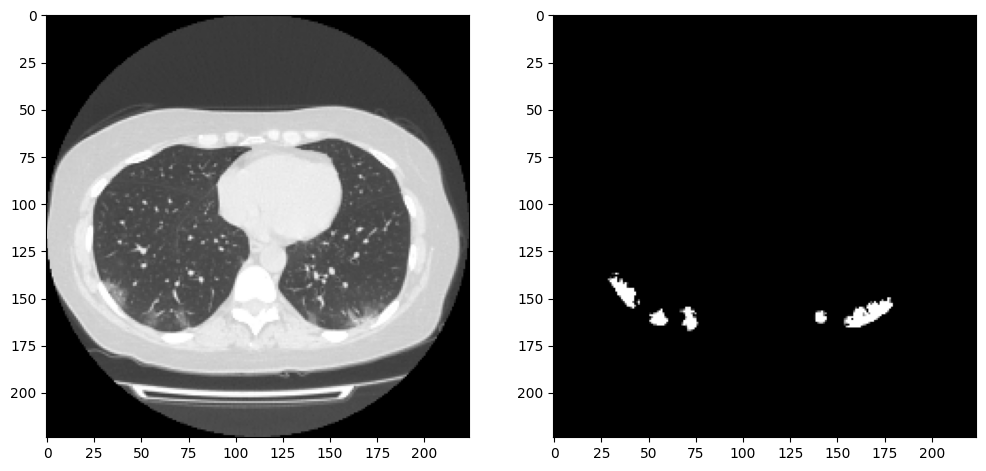

In [45]:
image_number = random.randint(0, len(test_images))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(test_images[image_number])
plt.subplot(122)
plt.imshow(test_masks[image_number], cmap='gray')
plt.show()

# CompactViT

In [46]:
def mlp(x, mlp_dim, dim, dropout_rate=0.1):
    x = L.Dense(mlp_dim, activation='swish')(x)
    x = L.Dropout(dropout_rate)(x)
    x = L.Dense(dim)(x)
    x = L.Dropout(dropout_rate)(x)
    return x
def transformer_encoder(x, num_heads, dim, mlp_dim):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(num_heads=num_heads,
                             key_dim=dim)(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, mlp_dim, dim)
    x = L.Add()([x, skip_2])

    return x
def compact_vit_block(inputs, num_filters, dim, patch_size=2, num_layers=1):
    B, H, W, C = inputs.shape

    # Patch Embeddings
    patch_embeddings = L.Conv2D(filters=dim,
                               kernel_size=patch_size,
                               strides=patch_size,
                               padding='valid',
                               use_bias=False)(inputs)
    patch_embeddings = L.BatchNormalization()(patch_embeddings)
    patch_embeddings = L.Activation('swish')(patch_embeddings)

    # Reshape x to Flattened Patches
    P = (H // patch_size) * (W // patch_size)
    N = dim
    patch_embeddings = L.Reshape((P, N))(patch_embeddings)

    # Positional Embeddings
    positional_embeddings = L.Embedding(input_dim=P, output_dim=N)(tf.range(P))
    x = patch_embeddings + positional_embeddings

    # Transformer Encoder
    for _ in range(num_layers):
        x = transformer_encoder(x, 8, dim, dim*2) ### num_heads of Multi Head Attention set to 8

    # Reshape it back
    x = L.Reshape((H // patch_size, W // patch_size, dim))(x)

    # Upsample back to the original size
    x = L.UpSampling2D(size=patch_size)(x)

    #1x1 conv
    x = L.Conv2D(filters=C,
                 kernel_size=1,
                 padding='same',
                 use_bias=False)(x)
    x = L.BatchNormalization()(x)
    x = L.Activation('swish')(x)

    # Concatenate
    x = L.Concatenate()([x, inputs])

    #3x3 conv
    x = L.Conv2D(filters=num_filters,
                 kernel_size=1,
                 padding='same',
                 use_bias=False)(x)
    x = L.BatchNormalization()(x)
    x = L.Activation('swish')(x)

    return x

# Channel and Spatial Attention

In [47]:
class SpatialAttentionModule(tf.keras.layers.Layer):
    def __init__(self, kernel_size=3):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(SpatialAttentionModule, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=kernel_size,
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same',
                                            activation=tf.nn.relu)
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=kernel_size,
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same',
                                            activation=tf.nn.relu)
        self.conv3 = tf.keras.layers.Conv2D(16, kernel_size=kernel_size,
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same',
                                            activation=tf.nn.relu)
        self.conv4 = tf.keras.layers.Conv2D(1, kernel_size=kernel_size,
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same',
                                            activation=tf.math.sigmoid)

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs,  axis=3)
        x = tf.stack([avg_out, max_out], axis=3)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)


class ChannelAttentionModule(tf.keras.layers.Layer):
    def __init__(self, ratio=8):
        '''
        paper: https://arxiv.org/abs/1807.06521
        code: https://gist.github.com/innat/99888fa8065ecbf3ae2b297e5c10db70
        '''
        super(ChannelAttentionModule, self).__init__()
        self.ratio = ratio
        self.gapavg = tf.keras.layers.GlobalAveragePooling2D()
        self.gmpmax = tf.keras.layers.GlobalMaxPooling2D()

    def build(self, input_shape):
        self.conv1 = tf.keras.layers.Conv2D(input_shape[-1]//self.ratio,
                                            kernel_size=1,
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)

        self.conv2 = tf.keras.layers.Conv2D(input_shape[-1],
                                            kernel_size=1,
                                            strides=1, padding='same',
                                            use_bias=True, activation=tf.nn.relu)
        super(ChannelAttentionModule, self).build(input_shape)

    def call(self, inputs):
        # compute gap and gmp pooling
        gapavg = self.gapavg(inputs)
        gmpmax = self.gmpmax(inputs)
        gapavg = tf.keras.layers.Reshape((1, 1, gapavg.shape[1]))(gapavg)
        gmpmax = tf.keras.layers.Reshape((1, 1, gmpmax.shape[1]))(gmpmax)
        # forward passing to the respected layers
        gapavg_out = self.conv2(self.conv1(gapavg))
        gmpmax_out = self.conv2(self.conv1(gmpmax))
        return tf.math.sigmoid(gapavg_out + gmpmax_out)

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[3]
        return (input_shape[0], output_len)

# PIE

In [48]:
def PIE(x, filters):
    y = Conv2D(filters, (3,3), activation='relu', padding='same')(x)
    y = BatchNormalization()(y)

    z = Conv2D(filters, (3,3), activation='relu', padding='same')(x)
    z = BatchNormalization()(z)
    z_skip = z
    z_ca = ChannelAttentionModule()(z)
    z_sa = SpatialAttentionModule()(z)
    z = Multiply()([z_ca, z_sa])

    z_concat = Concatenate()([z, z_skip])

    z = Conv2D(filters, (3,3), activation='relu', padding='same')(z_concat)
    z = BatchNormalization()(z)

    z = Add()([z, y])

    return z

# Residual Block

In [49]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    x1 = PIE(x, filters)
    shortcut = x1

    # First convolution layer
    x = SeparableConv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution layer
    x = SeparableConv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Adjusting shortcut connection shape if stride is not 1
    if stride != 1:
        shortcut = SeparableConv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Adding shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# ASPP

In [50]:
def ASPP(inputs):
    """ Image Pooling """
    shape = inputs.shape
    y1 = tf.keras.layers.AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False)(y1)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y1 = tf.keras.layers.Activation("relu")(y1)
    y1 = tf.keras.layers.UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False)(inputs)
    y2 = tf.keras.layers.BatchNormalization()(y2)
    y2 = tf.keras.layers.Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    y3 = tf.keras.layers.Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = tf.keras.layers.BatchNormalization()(y4)
    y4 = tf.keras.layers.Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = tf.keras.layers.BatchNormalization()(y5)
    y5 = tf.keras.layers.Activation("relu")(y5)

    y = tf.keras.layers.Concatenate()([y1, y2, y3, y4, y5])
    y = tf.keras.layers.Conv2D(256, 1, padding="same", use_bias=False)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation("relu")(y)

    return y

# CResPIE-SegViT

In [52]:
inputs = Input((224,224,3))

# Encoder

x = compact_vit_block(inputs, 64, 64, patch_size=16, num_layers=4)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = PIE(x, 64)
skip_1 = x


x = SeparableConv2D(64, (1,1), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = PIE(x, 64)
skip_2 = x

x = residual_block(x, filters=64)

x = SeparableConv2D(128, (1,1), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = PIE(x, 128)
skip_3 = x

x = residual_block(x, filters=128)

x = SeparableConv2D(256, (1,1), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
x = PIE(x, 256)
skip_4 = x

x = residual_block(x, filters=256)

x = SeparableConv2D(256, (1,1), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)

#ASPP
x = ASPP(x)

# Decoder
x = UpSampling2D(interpolation='bilinear')(x)
x = Concatenate()([x, skip_4])

x = SeparableConv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D(interpolation='bilinear')(x)
x = Concatenate()([x, skip_3])

x = SeparableConv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D(interpolation='bilinear')(x)
x = Concatenate()([x, skip_2])

x = SeparableConv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D(interpolation='bilinear')(x)
x = Concatenate()([x, skip_1])

x = SeparableConv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D(interpolation='bilinear')(x)
x = SeparableConv2D(1, (1,1), activation='sigmoid')(x)

In [53]:
model = Model(inputs, x)

In [54]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           49152     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 14, 14, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 14, 14, 64)           0         ['batch_normalization[0][0

In [55]:
#keras.utils.plot_model(model, show_shapes=True)

# Performance Metrics

In [56]:
smooth = 1e-5
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def voe_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    voe = 1.0 - (intersection / union)
    return voe

def rvd_metric(y_true, y_pred):
    volume_pred = tf.reduce_sum(y_pred)
    volume_gt = tf.reduce_sum(y_true)
    rvd = ((volume_pred - volume_gt) / volume_gt)
    return rvd

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    iou_score = intersection / (union + smooth)
    return iou_score

# Model Fitting

In [57]:
metrics = [precision, recall, f1_score, dice_coef, iou, voe_metric, rvd_metric]

In [58]:
filepath = "/kaggle/working/model.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_dice_coef",
                            verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

In [59]:
cosine_decay_restarts = tf.keras.optimizers.schedules.CosineDecayRestarts(
      initial_learning_rate=0.001,
      first_decay_steps=3000)

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cosine_decay_restarts),
              loss=dice_loss,
              metrics=metrics)

In [61]:
history = model.fit(X_train, y_train, 
                    validation_data=[X_test, y_test],
                    callbacks=callbacks,
                    epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.9856 - precision: 0.0153 - recall: 0.7190 - f1_score: 0.0300 - dice_coef: 0.0144 - iou: 0.0073 - voe_metric: 0.9927 - rvd_metric: 83.5896
Epoch 1: val_dice_coef improved from -inf to 0.01153, saving model to /kaggle/working/model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 81s 1s/step - loss: 0.9856 - precision: 0.0153 - recall: 0.7190 - f1_score: 0.0300 - dice_coef: 0.0144 - iou: 0.0073 - voe_metric: 0.9927 - rvd_metric: 83.5896 - val_loss: 0.9885 - val_precision: 0.0054 - val_recall: 0.8221 - val_f1_score: 0.0107 - val_dice_coef: 0.0115 - val_iou: 0.0058 - val_voe_metric: 0.9942 - val_rvd_metric: 92.9718
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.9763 - precision: 0.0285 - recall: 0.9096 - f1_score: 0.0553 - dice_coef: 0.0237 - iou: 0.0120 - voe_metric: 0.9880 - rvd_metric: 70.6495
Epoch 2: val_dice_coef did not improve from 0.01153
16/16 [==============================] - 7s 432ms/step - loss: 0.9763 - precision: 0.0285 - recall: 0.9096 - f1_score: 0.0553 - dice_coef: 0.0237 - iou: 0.0120 - voe_metric: 0.9880 - rvd_metric: 70.6495 - val_loss: 0.9887 - val_precision: 0.0050 - val_recall: 0.4981 - val_f1_score: 0.0100 - val_dice_coef: 0.0113 - val_iou: 0.0057 - val_voe_metric: 0.9943 -

# Performance Evaluation

In [64]:
model.load_weights('/kaggle/working/model.h5')

In [65]:
evaluation = model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 115ms/step - loss: 0.2442 - precision: 0.7700 - recall: 0.7440 - f1_score: 0.7565 - dice_coef: 0.7558 - iou: 0.6080 - voe_metric: 0.3920 - rvd_metric: -0.0278


In [66]:
print("Evaluation Metrics:-")
for metric_name, metric_value in zip(model.metrics_names, evaluation):
    print(f"{metric_name}={metric_value}")

Evaluation Metrics:-
loss=0.24424372613430023
precision=0.770032525062561
recall=0.7439913153648376
f1_score=0.7565404772758484
dice_coef=0.7557562589645386
iou=0.6079710721969604
voe_metric=0.39202892780303955
rvd_metric=-0.027848318219184875


In [67]:
# Assuming X_test and y_test are your test data
# Make predictions on the test data
y_pred = model.predict(X_test)

4/4 [==============================] - 2s 110ms/step


In [68]:
# Assuming X_test, y_test, and y_pred are numpy arrays
# Select a random index for visualization
index = np.random.randint(0, len(X_test))

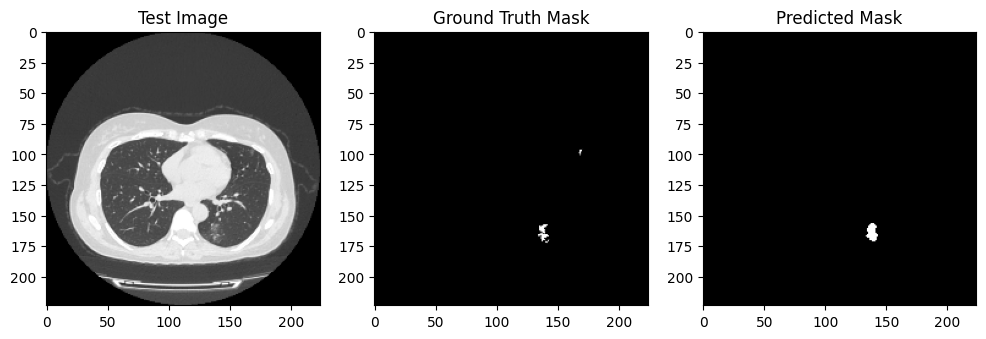

In [69]:
# Extract the corresponding test image, ground truth, and predicted mask
test_image = X_test[index]
ground_truth_mask = y_test[index]
predicted_mask = y_pred[index]

# Threshold the predicted mask to convert it into a binary mask
threshold = 0.5
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plot the figures
plt.figure(figsize=(12, 4))

# Plot the test image
plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title('Test Image')

# Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')

# Plot the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary, cmap='gray')
plt.title('Predicted Mask')

plt.show()

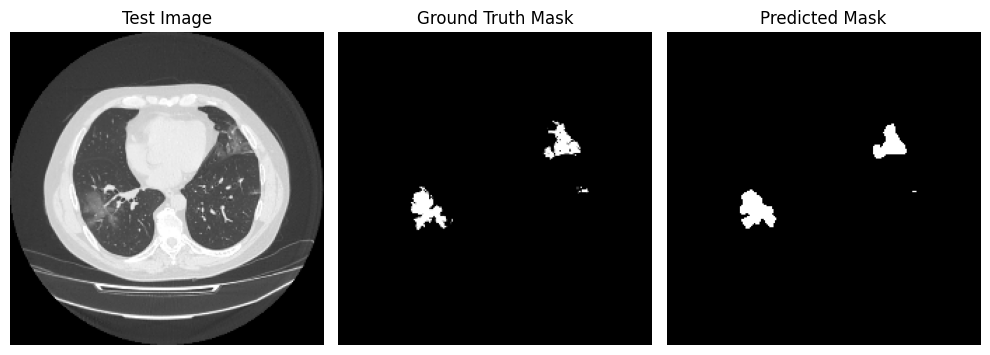

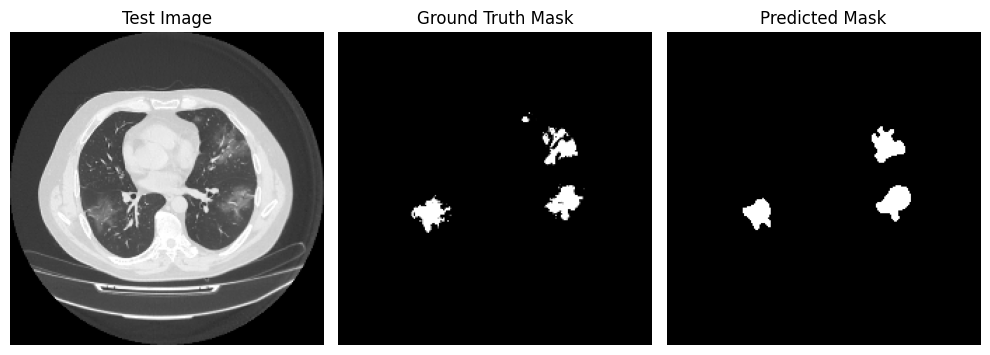

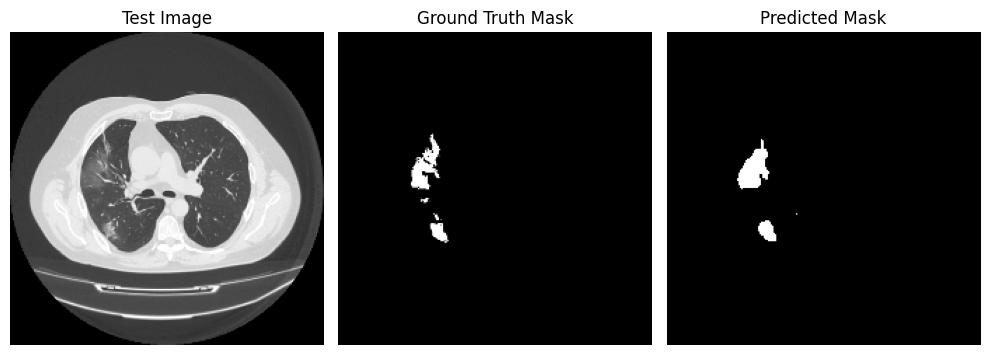

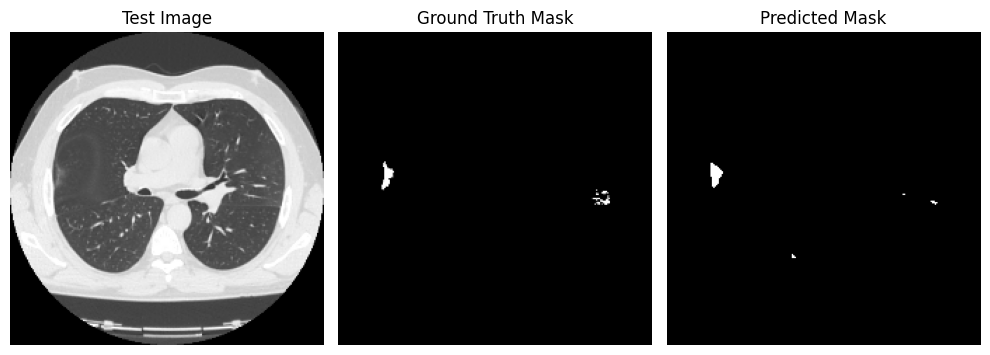

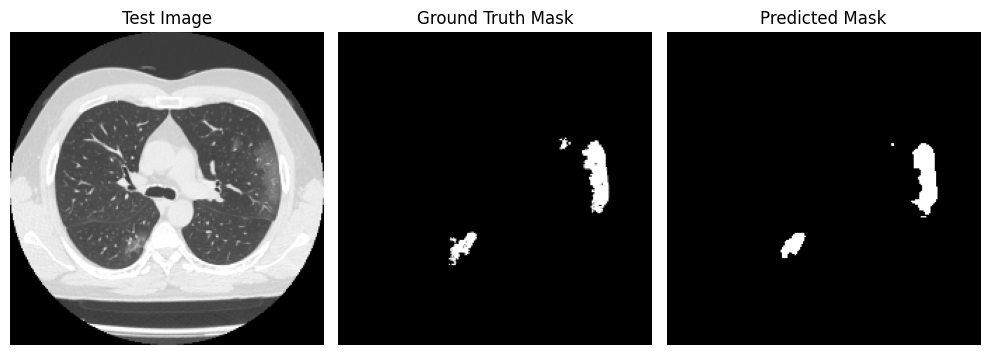

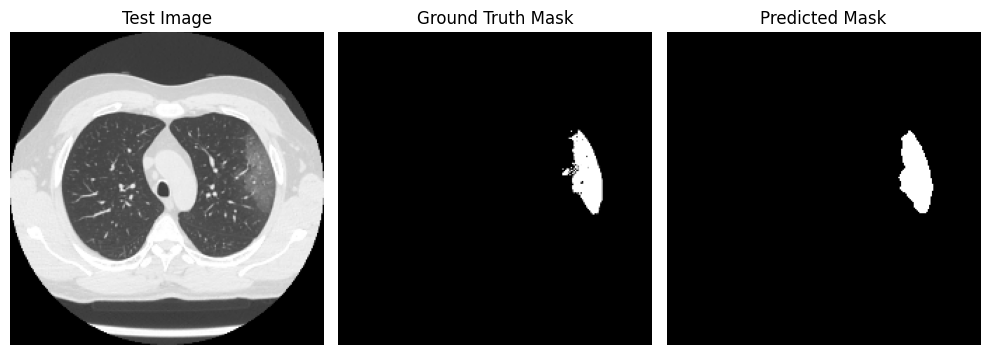

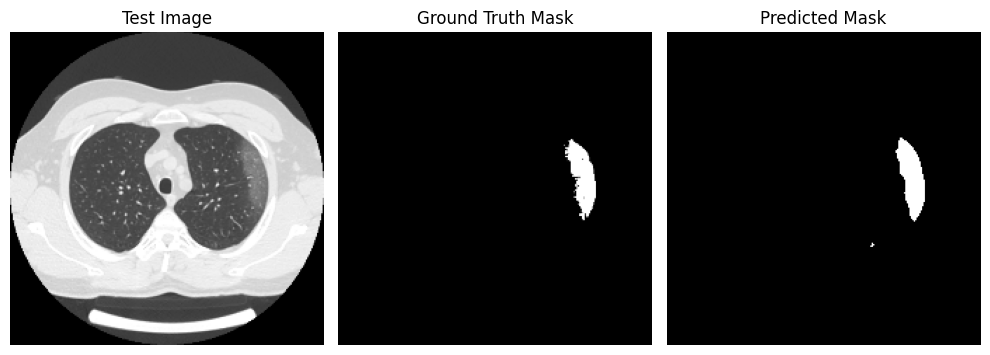

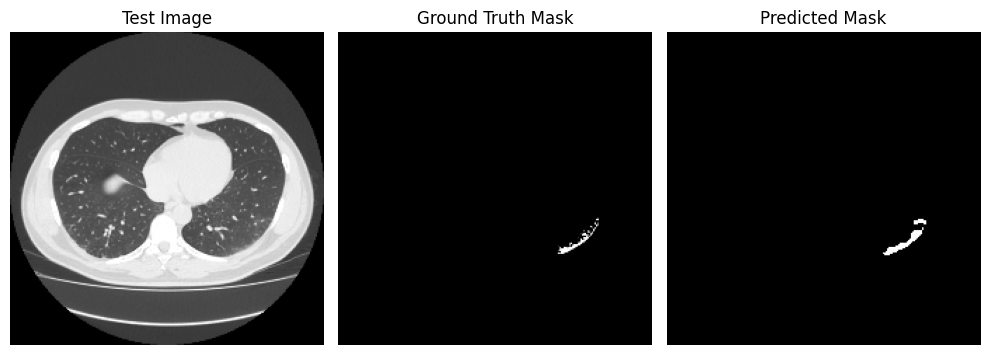

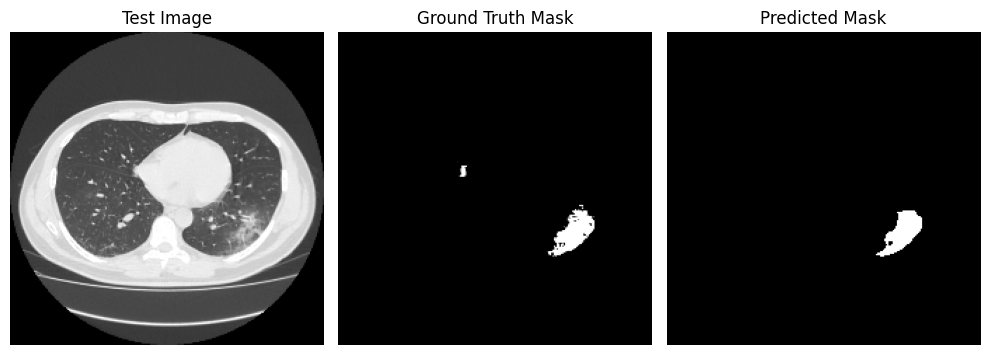

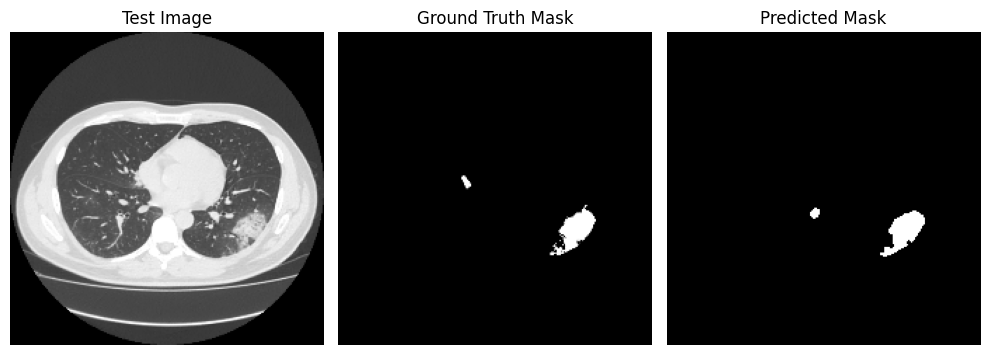

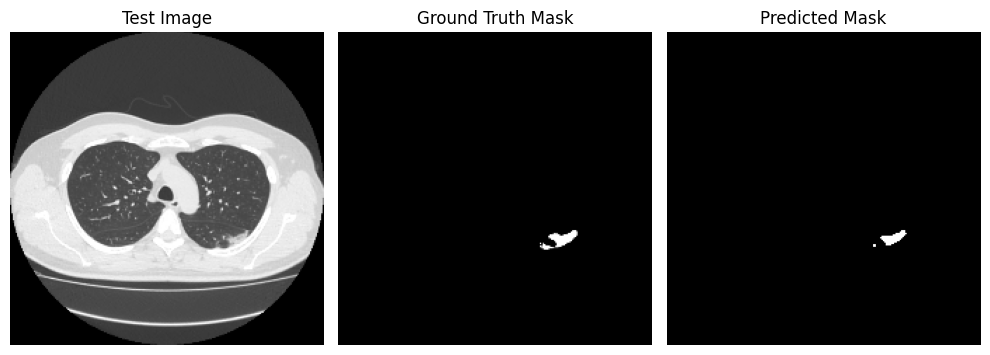

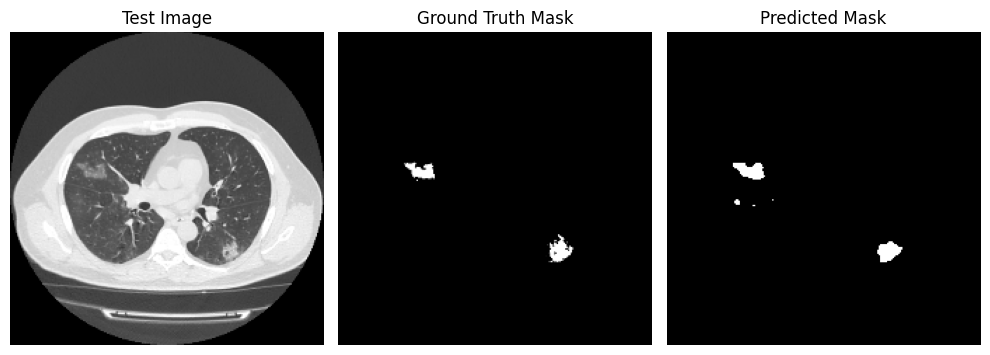

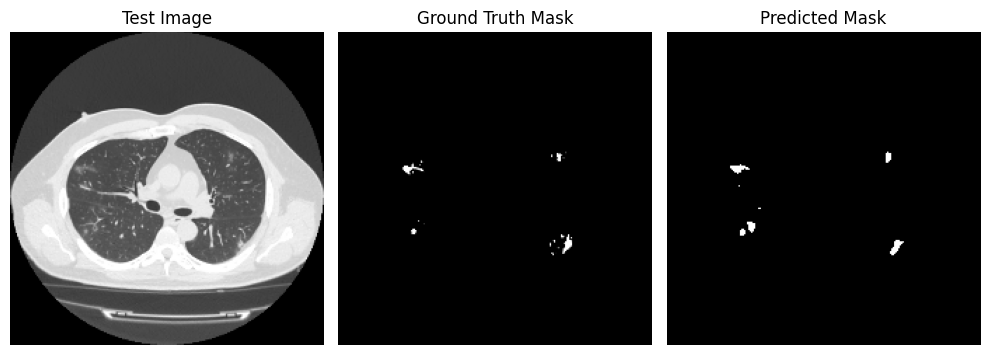

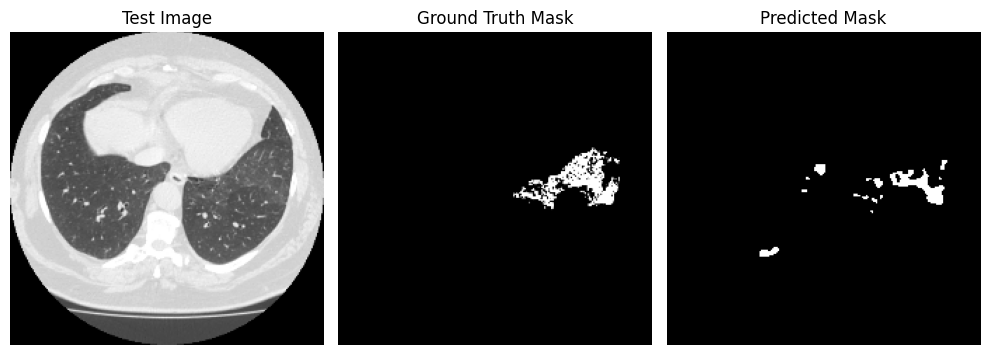

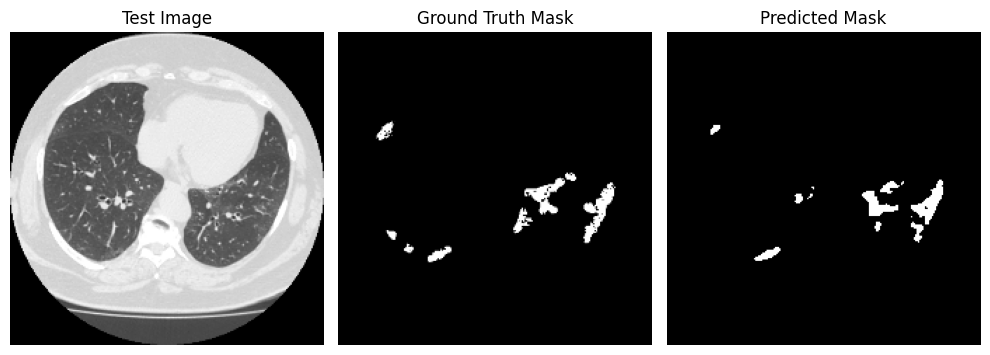

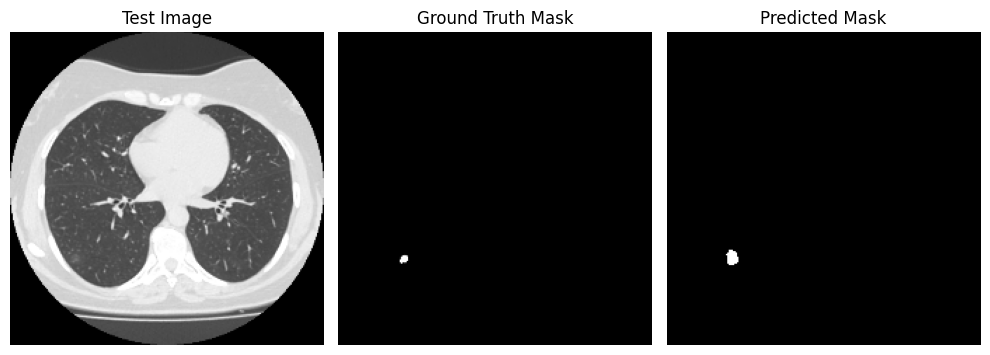

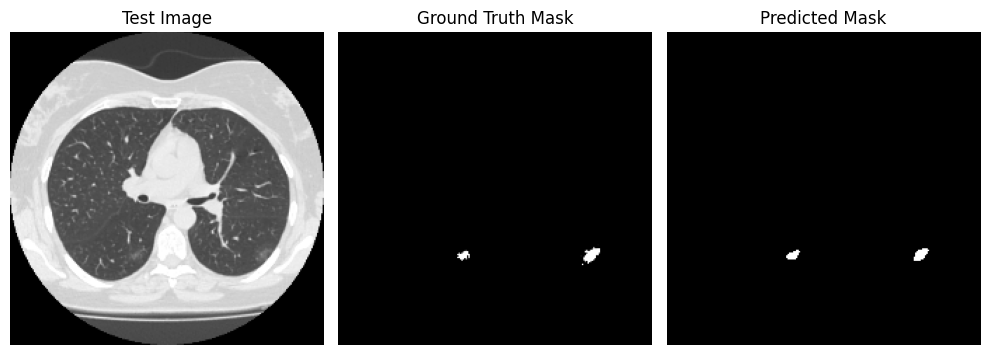

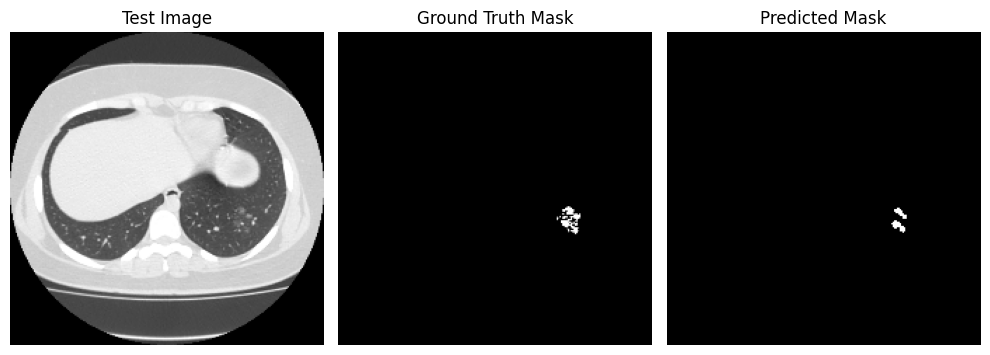

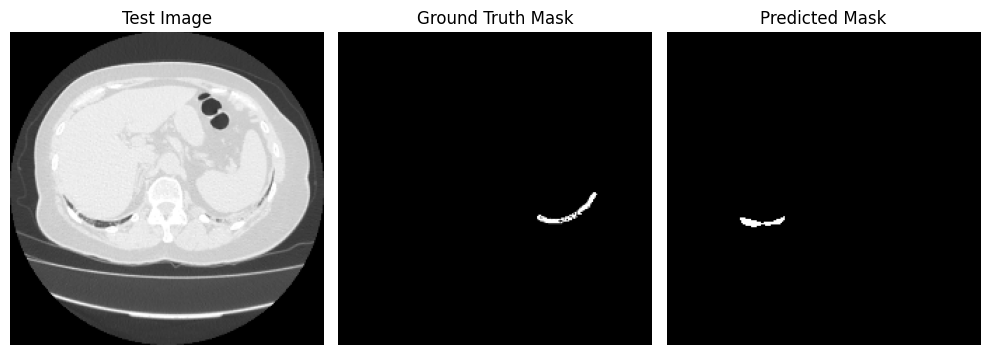

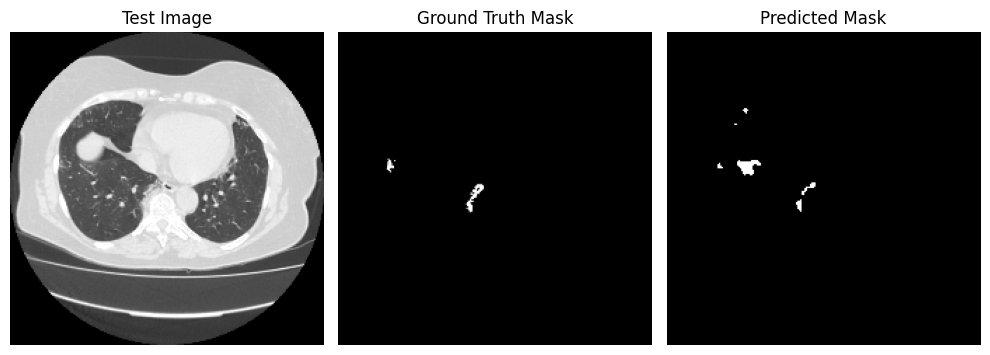

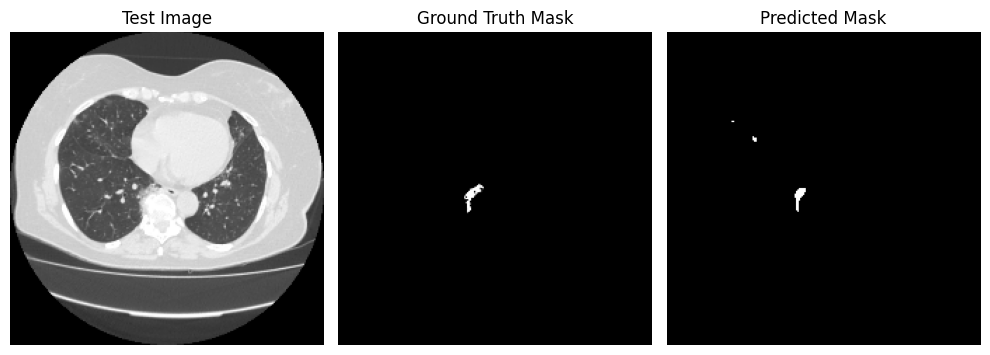

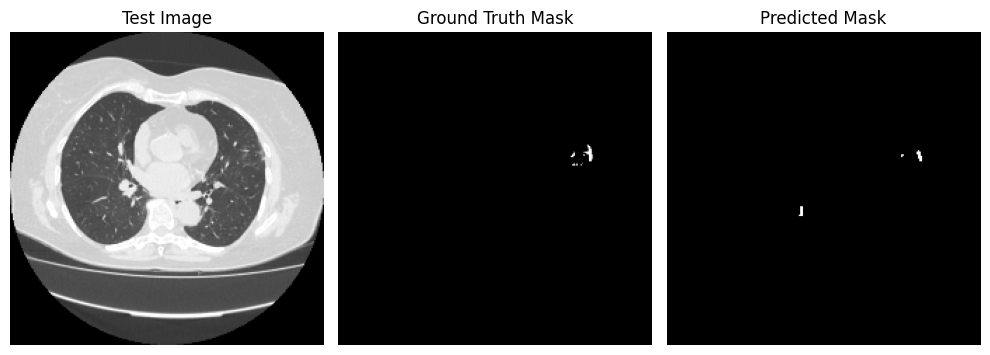

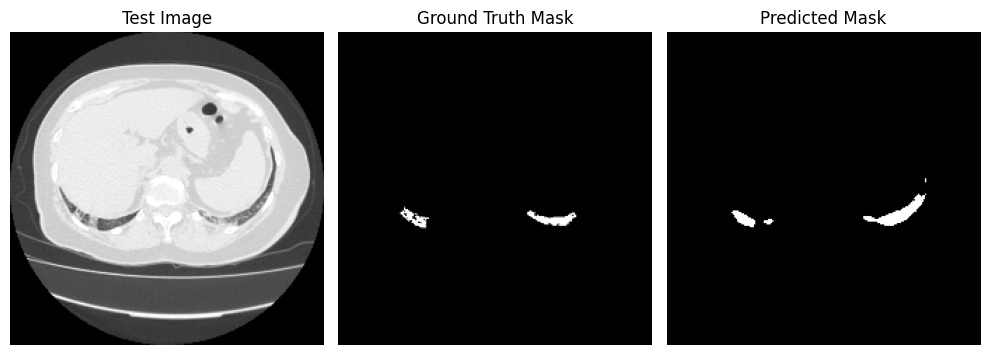

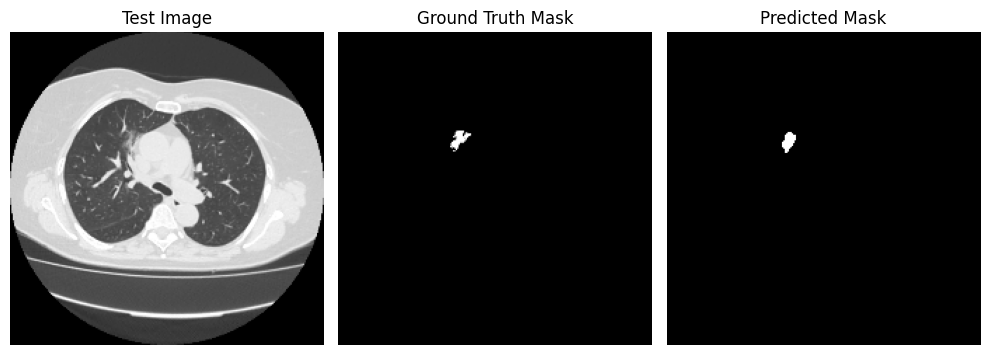

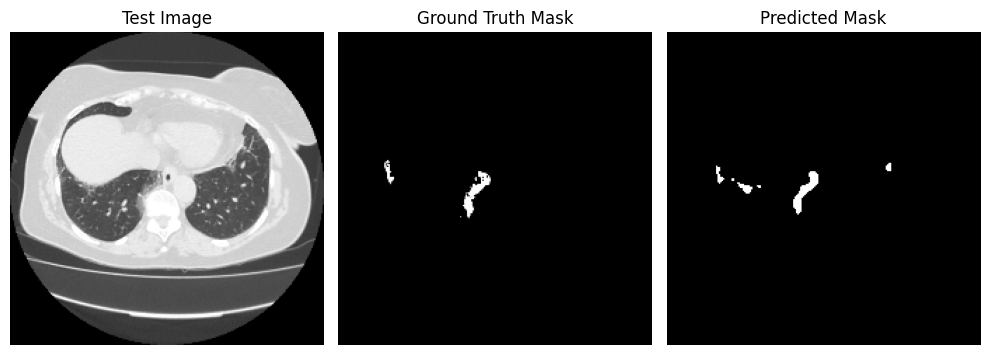

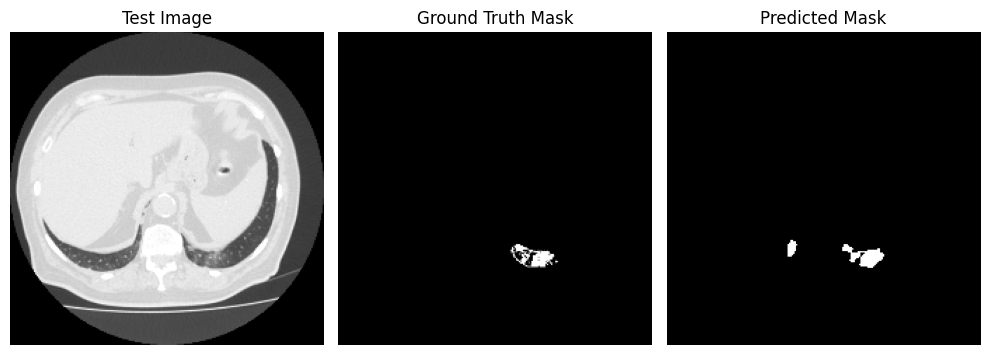

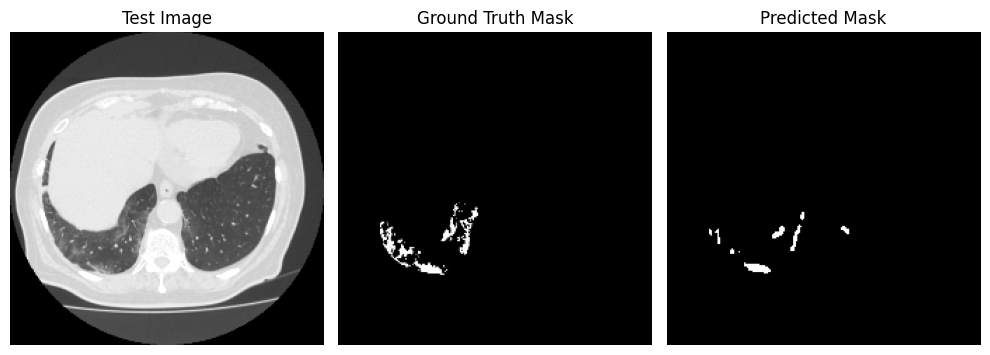

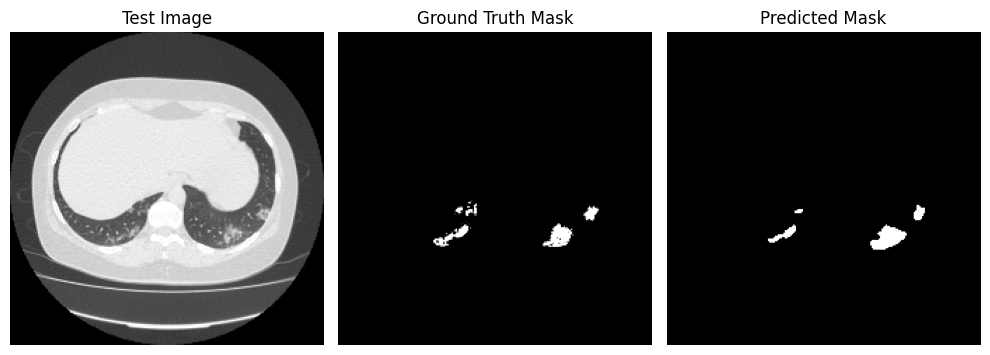

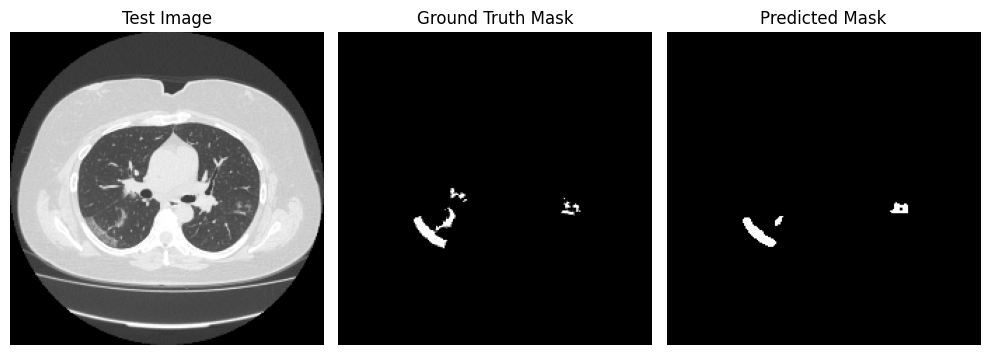

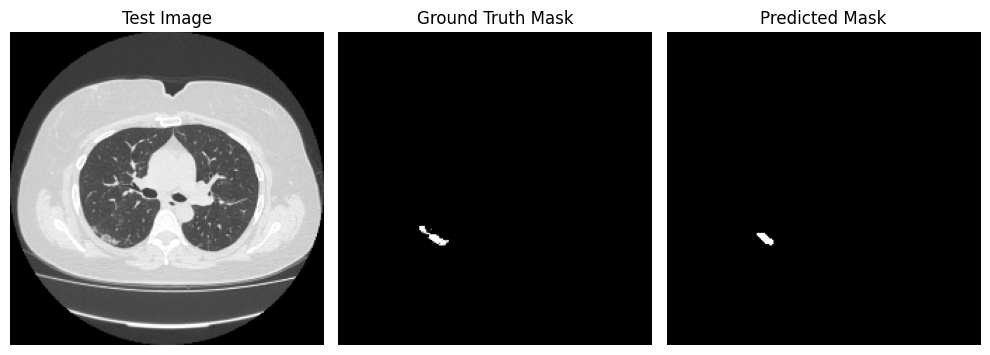

In [70]:
# Define the number of samples to visualize
num_samples = 30

for i in range(num_samples):
    # Extract the corresponding test image, ground truth, and predicted mask
    test_image = X_test[i]
    ground_truth_mask = y_test[i]
    predicted_mask = y_pred[i]

    # Threshold the predicted mask to convert it into a binary mask
    threshold = 0.5
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

    # Plot the figures
    plt.figure(figsize=(10, 10))

    # Plot the test image
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Test Image')
    plt.axis('off')

    # Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    
    plt.savefig(f'CResPIE-Seg-ViT-MosMed_{i}.png', dpi=600, bbox_inches='tight')
    plt.show()
